# CNN autoencoder metrics

In [1]:
# load custom packages from src dir
import sys
sys.path.insert(0, '..')

# python packages
import logging
import os
import numpy as np
import pandas as pd
import torch
import math
from tqdm import tqdm

# Viz
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# custom packages
import src.commons.constants as cons
from src.commons.segmentation_utils import get_scores, get_filled_score_map, plot_input_gt_score_bw_mask

# U-Net custom implementation
from src.models.u_net import *

# Define the logging level
logging.getLogger().setLevel(logging.INFO)

# Default size of matplotlib figures
matplotlib.rcParams['figure.figsize'] = [6, 4]

## Load the model

In [2]:
def load_the_category_model(category, resize_dim):
    CHECKPOINT_PATH = ".." + cons.DIR_SEP + os.path.join("results")
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_PATH, 'autoencoder_models')
    PATH = os.path.join(CHECKPOINT_PATH, f"autoencoder_{category}_resizedim_{resize_dim}.pt")
    DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # Load the model
    model = SegmentationNetwork(n_channels=3, n_classes=3).to(DEVICE)
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

## Metrics

In [3]:
import src.commons.internal_metrics as i_metrics
import src.commons.external_metrics as e_metrics

In [4]:
def get_pixel_level_metrics(inputs, recons, targets, idx, threshold=0.5):
    scores, _ = get_scores(inputs, recons, idx)
    fpr = i_metrics.get_fpr(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    prc = i_metrics.get_prc(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    iou = i_metrics.get_iou(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    return {'fpr': fpr, 'prc': prc, 'iou': iou}


def get_region_level_metrics(inputs, recons, targets, idx, threshold=0.5):
    scores, _ = get_scores(inputs, recons, idx)
    pro = i_metrics.get_pro(y_true=targets[idx][:,:,0], y_score=scores, threshold=threshold)
    return {'pro': pro}


def get_threshold_independent_metrics(inputs, recons, targets, idx, fill_gaps=False):
    scores, _ = get_scores(inputs, recons, idx)
    scores = scores.numpy()
    gt_mask = targets[idx][:,:,0].numpy()
    gt_mask = np.where(gt_mask > 0.5, 1, 0)
    if (gt_mask == 1).any():
        mroc = i_metrics.fpr_pro_iou_curves(y_true=gt_mask, y_score=scores, fill_gaps=fill_gaps)
        return mroc
    else: 
        logging.debug(f"This image {idx} is not anomalous.")
        return {}
    

def get_plot(inputs, recons, targets, idx, threshold=0.5, fill_gaps=False):
    scores, bw_scores = get_scores(inputs, recons, idx, threshold)
    if fill_gaps:
        bw_scores = get_filled_score_map(scores.numpy(), threshold)
    
    fig, axs = plt.subplots(1, 5, figsize=(8, 8))
    axs[0].imshow(inputs[idx])
    axs[0].set_title('Raw image')
    axs[0].axis('off')
    axs[1].imshow(recons[idx])
    axs[1].set_title('Generated image')
    axs[1].axis('off')
    axs[2].imshow(scores, cmap="Greys_r")
    axs[2].set_title('Score map')
    axs[2].axis('off')
    axs[3].imshow(bw_scores, cmap="Greys_r")
    axs[3].set_title('Score map binary')
    axs[3].axis('off')
    axs[4].imshow(targets[idx])
    axs[4].set_title('Target')
    axs[4].axis('off')
    fig.tight_layout()
    plt.show()


def get_auc_data(inputs, recons, targets, idx):
    scores, _ = get_scores(inputs, recons, idx)
    gt_mask = targets[idx][:,:,0].numpy()
    gt_mask = np.where(gt_mask > 0.5, 1, 0)
    if (gt_mask == 1).any():
        img_metrics = e_metrics.compute_pixelwise_retrieval_metrics(
            anomaly_segmentations=scores.numpy(), 
            ground_truth_masks=gt_mask
            )
        return img_metrics
    else: 
        logging.debug(f"This image {idx} is not anomalous.")
        return {}


def plot_pro_curve(mroc_py):
    fig, ax1 = plt.subplots(figsize=(4,4))
    ax2 = ax1.twinx()
    ax1.plot(mroc_py['fpr'], mroc_py['pro'])
    ax1.set_ylabel('PRO')
    ax1.set_xlabel('FPR')
    ax2.plot(mroc_py['fpr'], mroc_py['threshold'], color='gold', alpha=0.5)
    ax2.set_ylabel('Threshold', color='gold')
    plt.title('FPR PRO curve & respective threshold')
    plt.show()
    

## Calculate for all images in same category

In [5]:
def get_pixel_based_and_region_based_metrics_for_all_test_images(inputs_resh, recons_resh, targets_resh):
    pixel_based, region_based = [], []
    
    # to select the threshold
    pbar = tqdm(enumerate(inputs_resh), total=len(inputs_resh))
    for idx, batch in pbar:
        # Pixel based | ROC curve
        pixel_based.append(get_auc_data(inputs_resh, recons_resh, targets_resh, idx-1))
        # Region based | PRO curve
        region_based.append(get_threshold_independent_metrics(inputs_resh, recons_resh, targets_resh, idx-1, fill_gaps=False))
    return {'pixel_based': pixel_based, 'region_based': region_based}

In [6]:
def get_aurocs_of_all_test_images(pixel_based):
    df_thr_indep_results = pd.DataFrame()
    aurocs = []
    pixel_based_clean = [x for x in pixel_based if x != {}]
    for i in range(len(pixel_based_clean)):
        auroc = pixel_based_clean[i]['auroc']
        if torch.is_tensor(auroc):
            aurocs.append(auroc.numpy()*1)
        else:
            aurocs.append(auroc)
    
    df_thr_indep_results['auroc'] = aurocs
    return df_thr_indep_results

In [7]:
def build_pro_fpr_curve_with_all_test_images(category, region_based, resize_dim):
    regions_anomalies = np.array([x for x in region_based if x != {}])
    proaucs = np.array([results['proauc'] for results in region_based if results != {}])
    pros = np.array([x['pro'] for x in region_based if x != {}])
    fprs = np.array([x['fpr'] for x in region_based if x != {}])

    # get median of each position
    len_pros = [len(x) for x in pros]
    median_pros, median_fprs = [], []
    
    for i in range(np.min(len_pros)):
        all_pro_i = np.array([pro[i] for pro in pros])
        all_fpr_i = np.array([fpr[i] for fpr in fprs])
        median_pros.append(np.median(all_pro_i))
        median_fprs.append(np.median(all_fpr_i))
    
    fpr_steps = [x for x in np.arange(0, 0.325, 0.025)]

    bucket_for_fprs = {}
    for fpr in fpr_steps:
        df_pro_in_range = []
        for img_results in regions_anomalies:
            df_img_results = pd.DataFrame({'fpr': img_results['fpr'], 'pro': img_results['pro']})
            df_pro_in_range_tmp = df_img_results[(df_img_results['fpr'] >= fpr) & (df_img_results['fpr'] < (fpr + 0.025))].pro.values
            df_pro_in_range.extend(df_pro_in_range_tmp)
        bucket_for_fprs[f'{fpr}'] = df_pro_in_range

    results_path = ".." + cons.DIR_SEP + os.path.join("results")
    results_path = os.path.join(results_path, 'autoencoder_pro_fpr')
    results_path = os.path.join(results_path, f"autoencoder_{category}_resizedim_{resize_dim}.png")

    plt.rcParams['font.size'] = 10
    
    plt.boxplot([bucket_for_fprs[k] for k in bucket_for_fprs.keys()], positions=[round(float(k), 3) for k in bucket_for_fprs.keys()], widths=([0.01] * len(bucket_for_fprs.keys())), showfliers=False)
    plt.plot(fprs[proaucs.argmin()], pros[proaucs.argmin()], label=f'min AU-PRO: {proaucs.min():.3f}')
    plt.plot(fprs[proaucs.argmax()], pros[proaucs.argmax()], label=f'max AU-PRO: {proaucs.max():.3f}')
    plt.plot([0, 0.3], [0, 1], color='gray', alpha=0.2)
    plt.xlim((-0.0125, 0.3))
    plt.xlabel('FPR')
    plt.ylabel('PRO')
    plt.xticks(rotation=45)
    plt.title(f'PRO FPR curve for "{category}" category with {resize_dim} dim.', fontsize=12)
    plt.legend()
    plt.savefig(results_path)
    plt.show()


In [8]:
def plot_matrix_of_pro_curves_1_for_each_test_image(results):
    plt.rcParams['font.size'] = 6
    results = [r for r in results if r != {}]
    total_r = len(results)
    total_cols = 5
    total_lines = math.ceil(total_r / total_cols)

    fig, ax1 = plt.subplots(total_lines, total_cols, figsize=(total_cols*3 , total_lines*3))
    for n in range(total_r):
        i = math.floor(n/total_cols)
        j = n - total_cols*i
        ax2 = ax1[i][j].twinx()
        ax1[i][j].plot(results[n]['fpr'], results[n]['pro'])
        ax1[i][j].set_ylabel('PRO')
        ax1[i][j].set_xlabel('FPR')
        ax2.plot(results[n]['fpr'], results[n]['threshold'], color='gold', alpha=0.5)
        ax2.set_ylabel('Threshold', color='gold')
    plt.show()
    plt.rcParams['font.size'] = 12

In [9]:
def get_metrics_for_optimal_threshold_all_test_images(pixel_based, inputs_resh, recons_resh, targets_resh):
    # Performance after threshold is selected
    optimal_thresholds = np.array([results['optimal_threshold'] for results in pixel_based if results != {}])
    threshold = round(np.median(optimal_thresholds), 4)
    pixel_based_th, region_based_th = [], []
    
    pbar = tqdm(enumerate(inputs_resh), total=len(inputs_resh))
    for idx, batch in pbar:
        # Pixel based | FPR, PRC, IoU
        pixel_based_th.append(get_pixel_level_metrics(inputs_resh, recons_resh, targets_resh, idx-1, threshold=threshold))
        # Region based | PRO
        region_based_th.append(get_region_level_metrics(inputs_resh, recons_resh, targets_resh, idx-1, threshold=threshold))
        region_based_th[idx]['pro']

    df_thr_based_results = pd.DataFrame()
    fprs, prcs, ious, pros = [], [], [], []
    for i in range(len(pixel_based_th)):
        fpr = pixel_based_th[i]['fpr']
        prc = pixel_based_th[i]['prc']
        iou = pixel_based_th[i]['iou']
        pro = region_based_th[i]['pro']
        if torch.is_tensor(fpr):
            fprs.append(fpr.numpy()*1)
        else: 
            fprs.append(fpr)
        if torch.is_tensor(prc):
            prcs.append(prc.numpy()*1)
        else:
            prcs.append(prc)
        if torch.is_tensor(iou):
            ious.append(iou.numpy()*1)
        else:
            ious.append(iou)
        if torch.is_tensor(pro):
            pros.append(pro.numpy()*1)
        else:
            pros.append(pro)
    
    df_thr_based_results['fpr'] = fprs
    df_thr_based_results['prc'] = prcs
    df_thr_based_results['iou'] = ious
    df_thr_based_results['pro'] = pros
    
    return threshold, df_thr_based_results
        

## Metrics for all categories

1. AUROCs statistics for each category
    1. Build a table with each category AUROC mean
    1. Build a box plot chart with a box plot for each category
1. PRO FPR curve with the boxplots per FPR step up to 30% - 1 chart per category
1. With the optimal threshold calculated (with F1 estimation), build a table with: Threshold, FPR, PRC, IoU, PRO (1 row per category)

In [10]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
def run_all(category, resize_dim):
    ## in the loop
    model = load_the_category_model(category, resize_dim)
    test_data = load_test_data(category, batch_size=4)
    inputs, recons, targets = predict(model, test_data['test'], resize_dim=resize_dim)
    # reorganise dimensions
    inputs_resh = einops.rearrange(inputs, "n b c h w -> (n b) h w c")
    recons_resh = einops.rearrange(recons, "n b c h w -> (n b) h w c")
    targets_resh = einops.rearrange(targets, "n b c h w -> (n b) h w c")
    # compute treshold independent metrics
    pixel_and_region_results = get_pixel_based_and_region_based_metrics_for_all_test_images(inputs_resh, recons_resh, targets_resh)
    pixel_based = pixel_and_region_results['pixel_based']
    region_based = pixel_and_region_results['region_based']
    # AUROC
    df_thr_indep_results = get_aurocs_of_all_test_images(pixel_based)
    # return AUROC
    auroc = df_thr_indep_results.describe().T

    # PRO FPR curve: saved under resuts/autoencoder_pro_fpr/ with name of category and resize-dim
    build_pro_fpr_curve_with_all_test_images(category, region_based, resize_dim)
    # compute threshold based metrics
    optimal_threshold, df_thr_based_results = get_metrics_for_optimal_threshold_all_test_images(pixel_based, inputs_resh, recons_resh, targets_resh)
    # return treshold based results + optimal threshold
    treshold_based_results = df_thr_based_results.describe()

    return {'auroc': auroc, 'optimal_threshold': optimal_threshold, 'threshold_based_metrics': treshold_based_results}


In [12]:
all_categories = [ 
    'bottle', 
    'cable', 
    'capsule', 
    'carpet', 
    'grid', 
    'hazelnut', 
    'leather', 
    'metal_nut', 
    'pill', 
    'screw', 
    'tile', 
    'toothbrush', 
    'transistor', 
    'wood', 
    'zipper'
    ]

all_resize_dim = [100, 200, 400]

100%|██████████| 80/80 [00:01<00:00, 75.47it/s] 


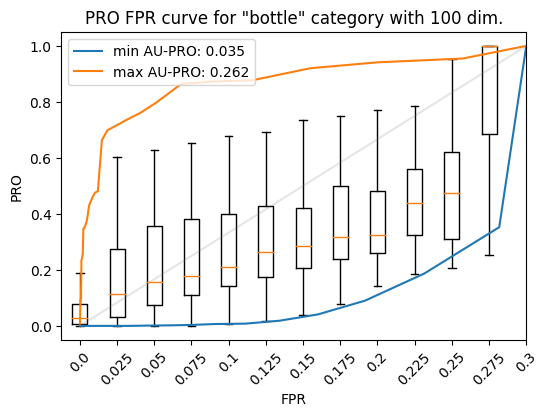

100%|██████████| 80/80 [00:03<00:00, 21.62it/s]


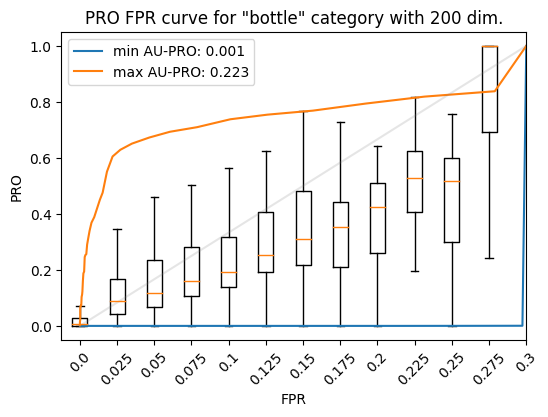

100%|██████████| 80/80 [00:11<00:00,  7.12it/s]


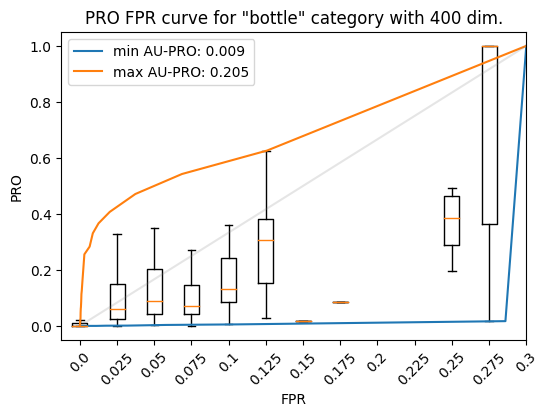

100%|██████████| 148/148 [00:02<00:00, 72.86it/s]


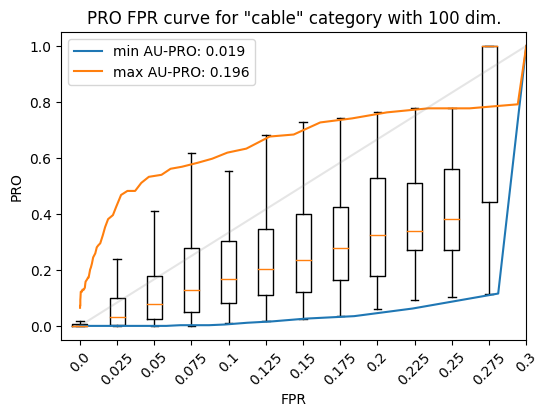

100%|██████████| 148/148 [00:06<00:00, 21.91it/s]


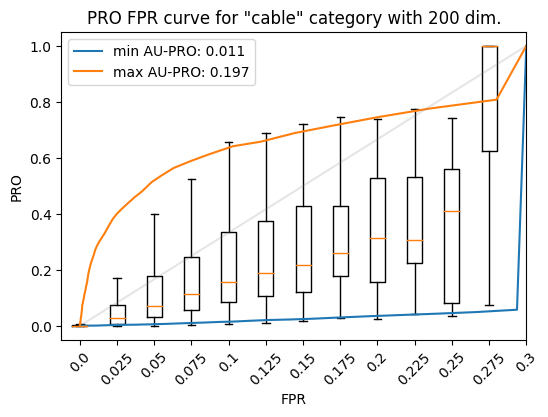

100%|██████████| 148/148 [00:27<00:00,  5.45it/s]


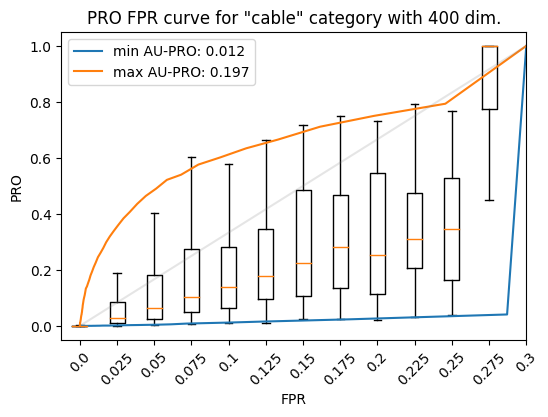

100%|██████████| 128/128 [00:02<00:00, 63.65it/s]


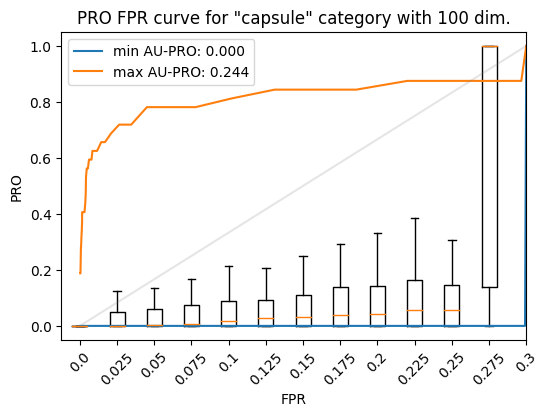

100%|██████████| 128/128 [00:05<00:00, 21.39it/s]


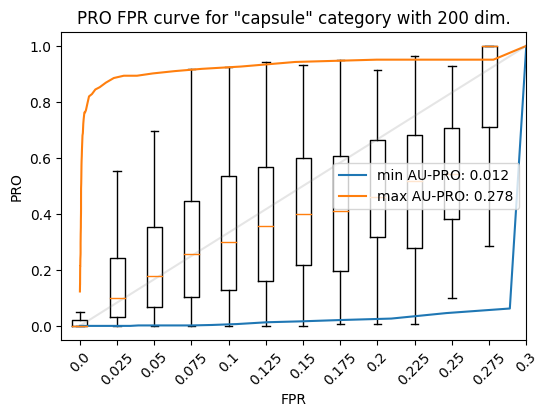

100%|██████████| 128/128 [00:19<00:00,  6.73it/s]


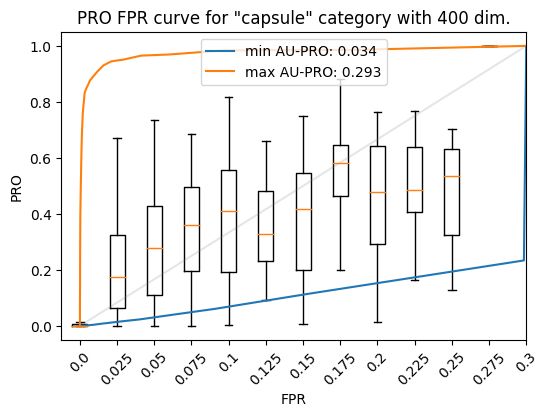

100%|██████████| 116/116 [00:01<00:00, 67.20it/s]


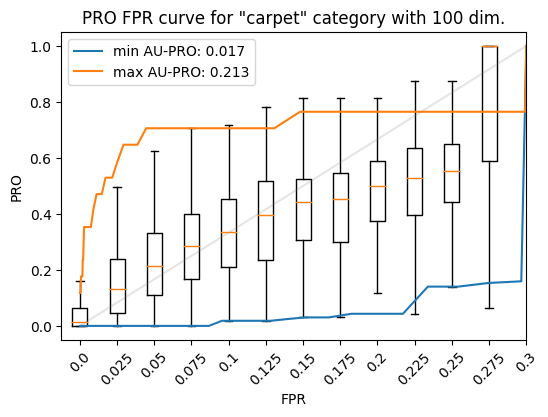

100%|██████████| 116/116 [00:05<00:00, 20.76it/s]


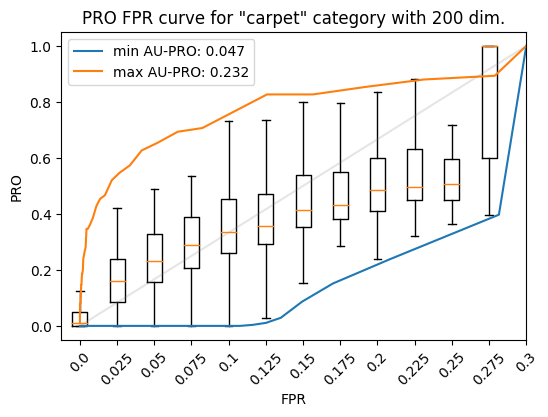

100%|██████████| 116/116 [00:21<00:00,  5.40it/s]


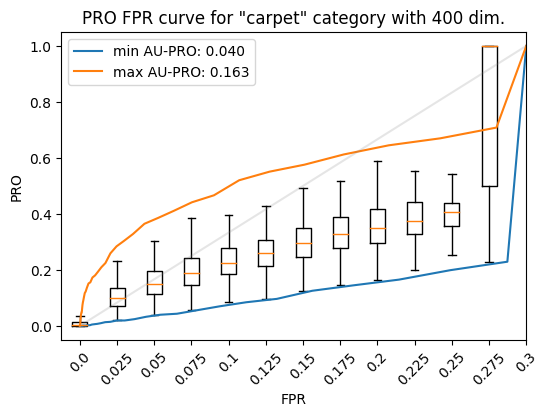

100%|██████████| 76/76 [00:01<00:00, 44.72it/s]


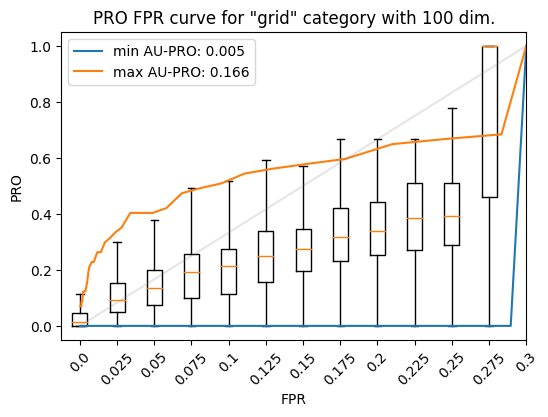

100%|██████████| 76/76 [00:04<00:00, 17.77it/s]


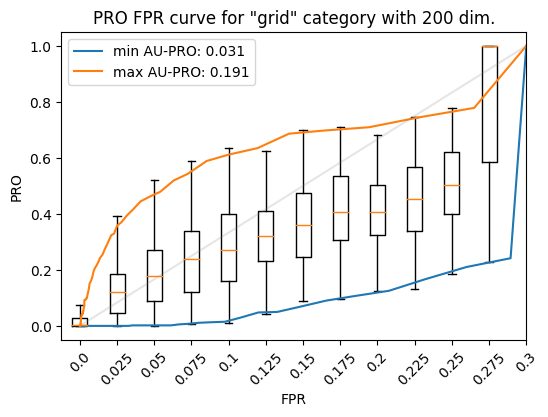

100%|██████████| 76/76 [00:15<00:00,  4.80it/s]


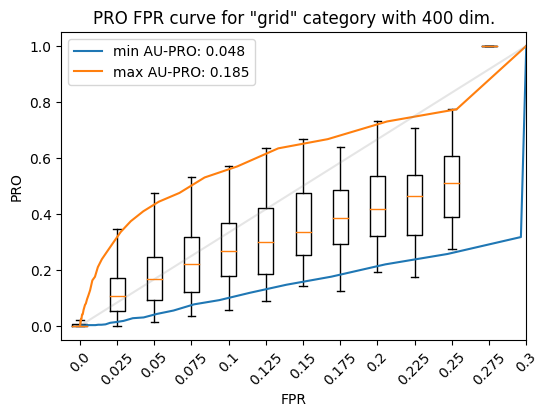

100%|██████████| 108/108 [00:01<00:00, 71.16it/s]


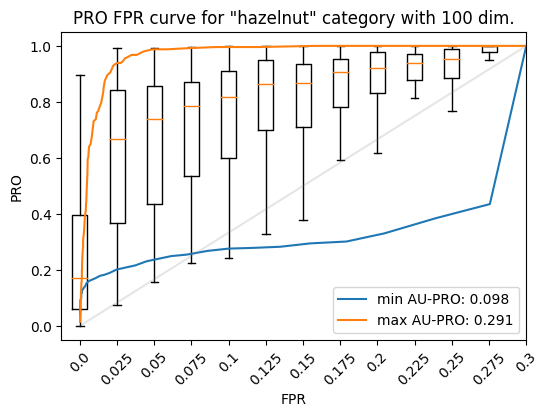

100%|██████████| 108/108 [00:05<00:00, 21.31it/s]


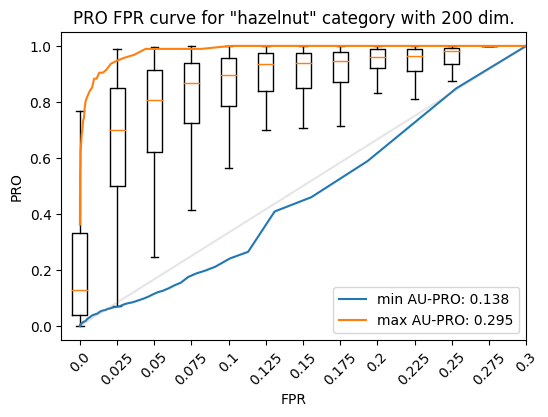

100%|██████████| 108/108 [00:19<00:00,  5.53it/s]


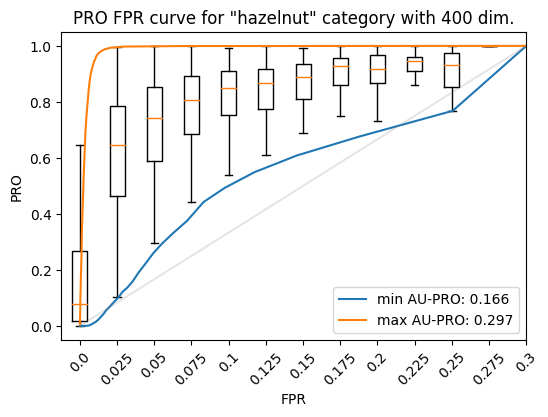

100%|██████████| 120/120 [00:01<00:00, 71.95it/s]


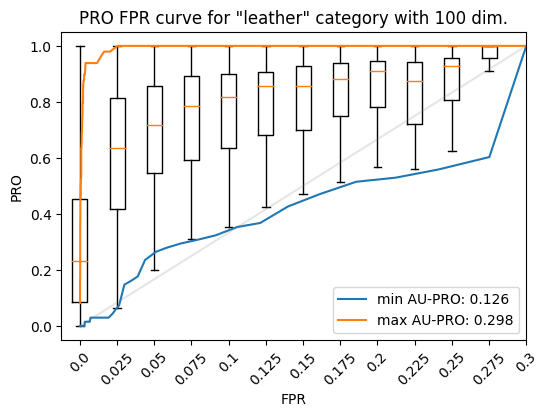

100%|██████████| 120/120 [00:05<00:00, 22.14it/s]


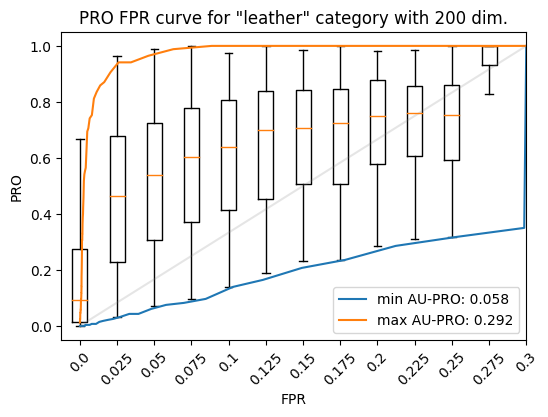

100%|██████████| 120/120 [00:22<00:00,  5.39it/s]


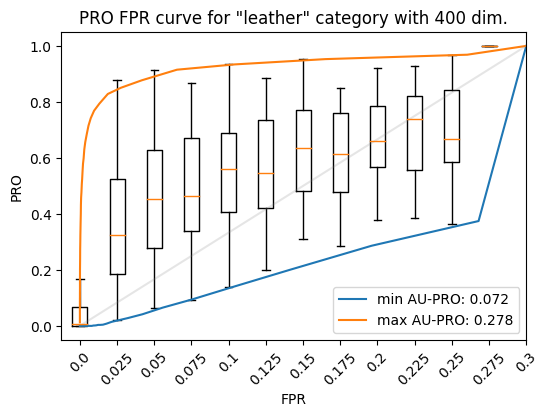

100%|██████████| 112/112 [00:02<00:00, 55.66it/s]


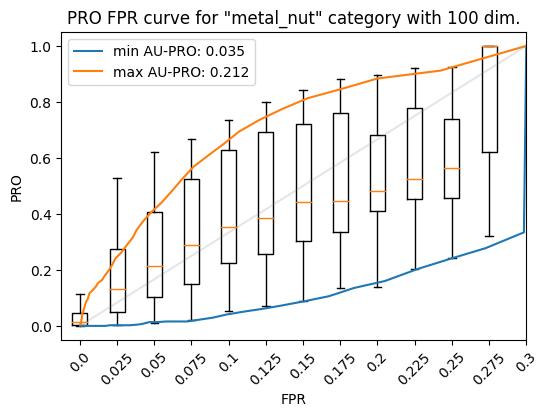

100%|██████████| 112/112 [00:06<00:00, 17.32it/s]


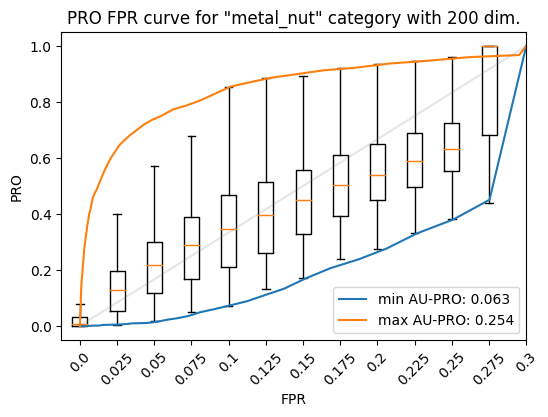

100%|██████████| 112/112 [00:25<00:00,  4.44it/s]


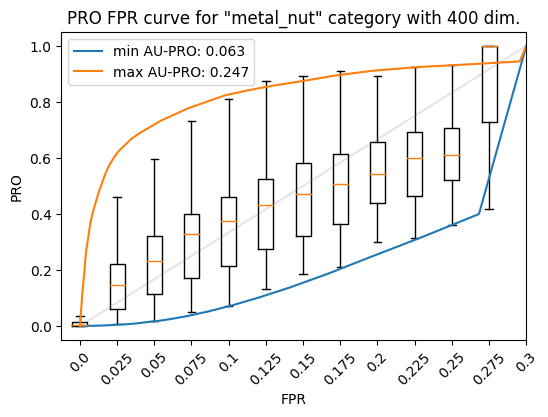

100%|██████████| 164/164 [00:02<00:00, 59.08it/s] 


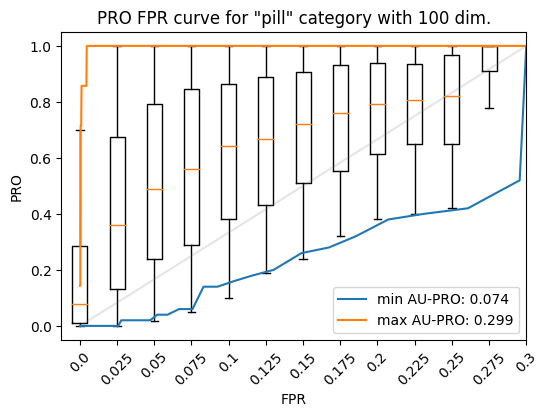

100%|██████████| 164/164 [00:09<00:00, 17.57it/s]


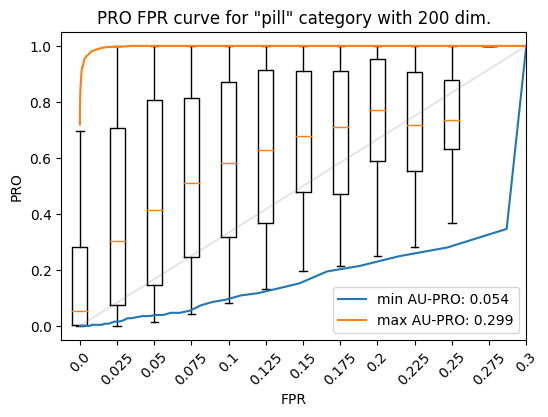

100%|██████████| 164/164 [00:37<00:00,  4.35it/s]


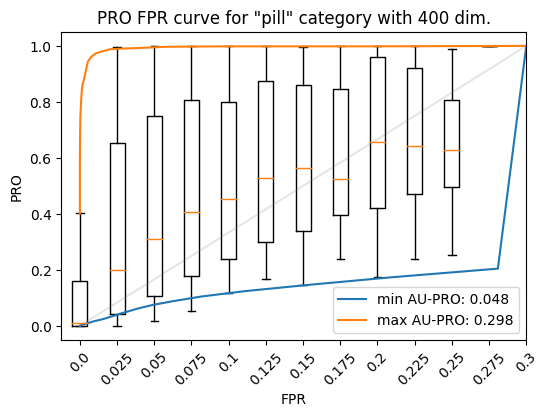

100%|██████████| 156/156 [00:02<00:00, 73.83it/s] 


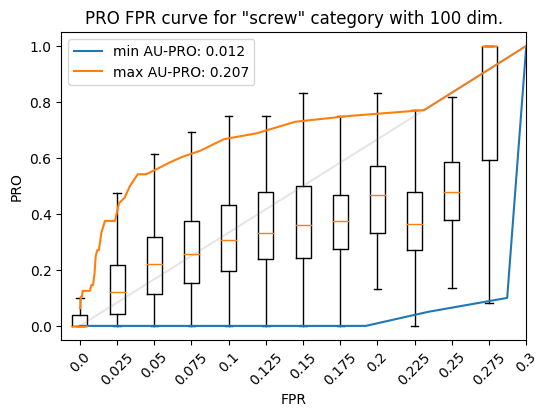

100%|██████████| 156/156 [00:06<00:00, 24.82it/s] 


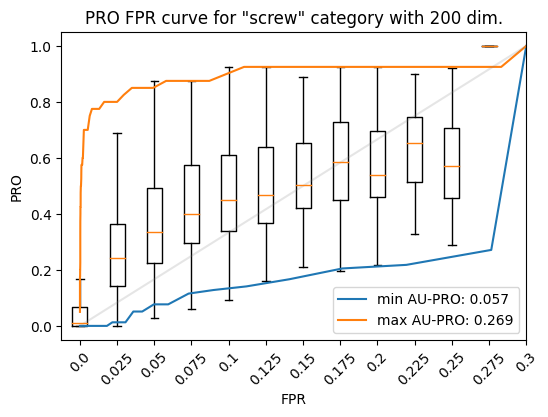

100%|██████████| 156/156 [00:23<00:00,  6.69it/s]


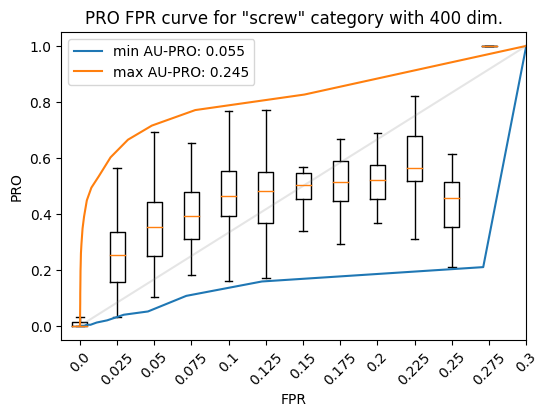

100%|██████████| 116/116 [00:01<00:00, 64.25it/s]


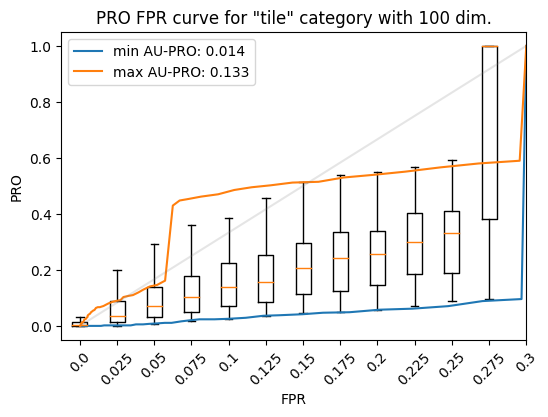

100%|██████████| 116/116 [00:05<00:00, 21.22it/s]


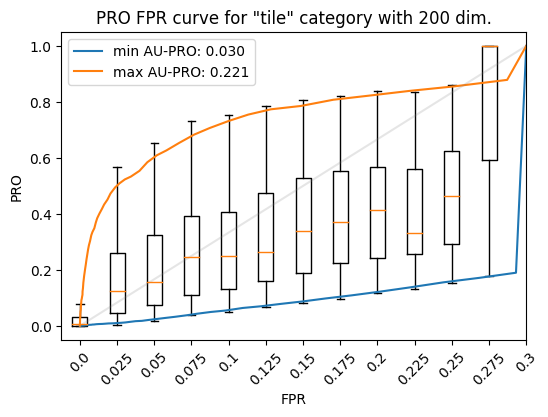

100%|██████████| 116/116 [00:21<00:00,  5.38it/s]


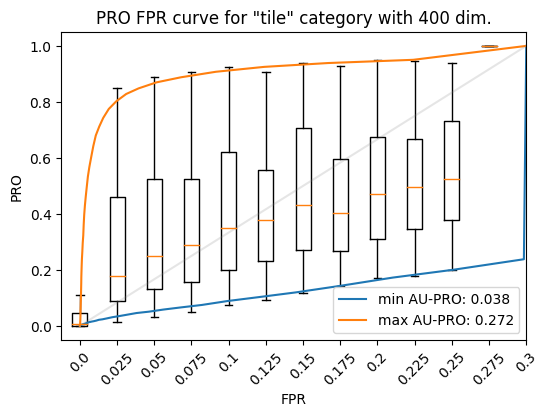

100%|██████████| 40/40 [00:00<00:00, 52.24it/s]


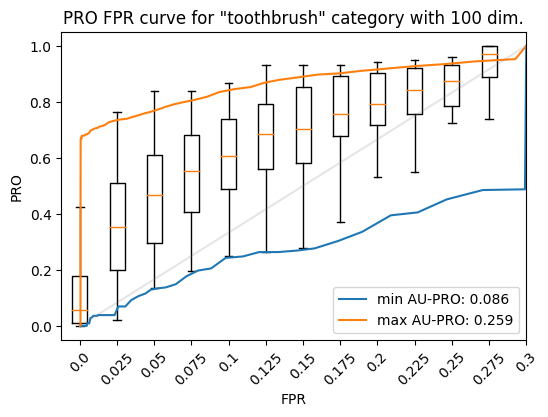

100%|██████████| 40/40 [00:02<00:00, 16.40it/s]


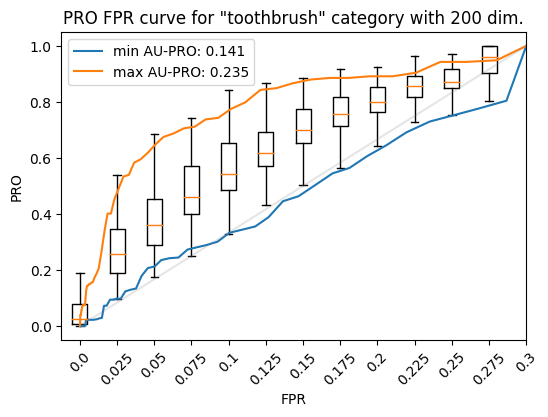

100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


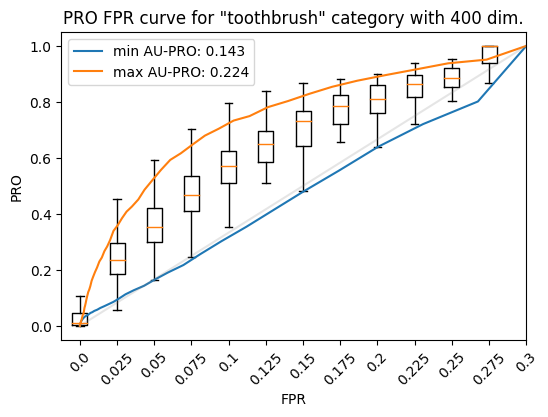

100%|██████████| 96/96 [00:00<00:00, 108.61it/s]


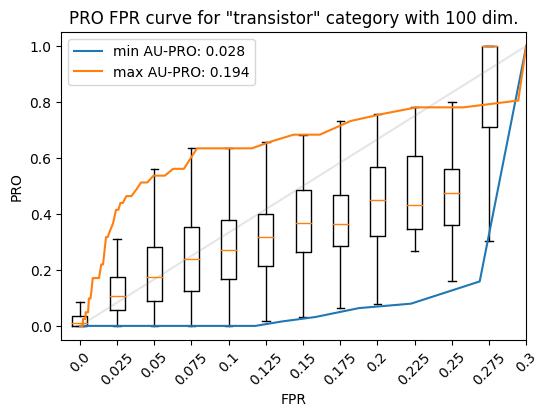

100%|██████████| 96/96 [00:02<00:00, 36.91it/s] 


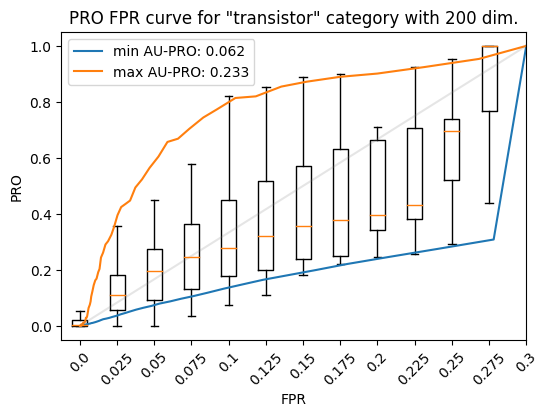

100%|██████████| 96/96 [00:10<00:00,  9.16it/s]


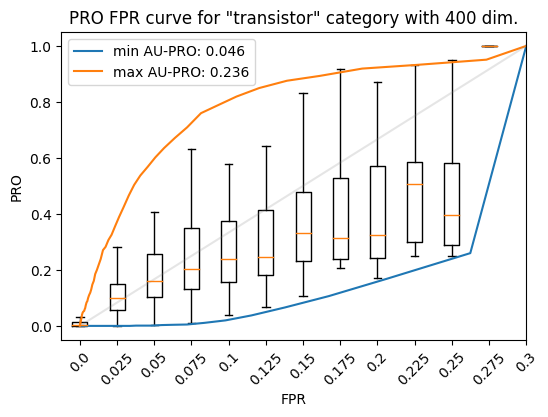

100%|██████████| 76/76 [00:01<00:00, 60.98it/s]


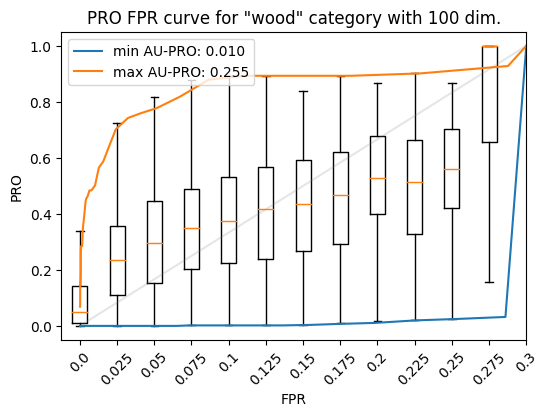

100%|██████████| 76/76 [00:04<00:00, 18.49it/s]


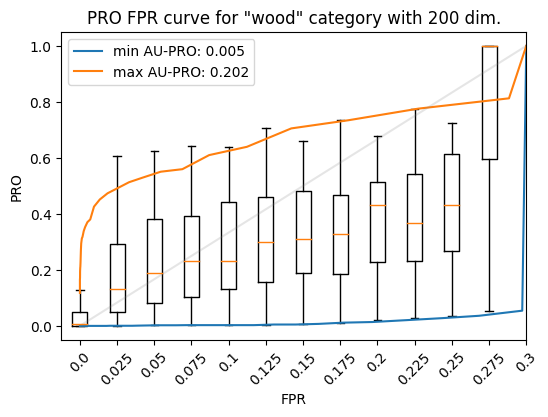

100%|██████████| 76/76 [00:17<00:00,  4.45it/s]


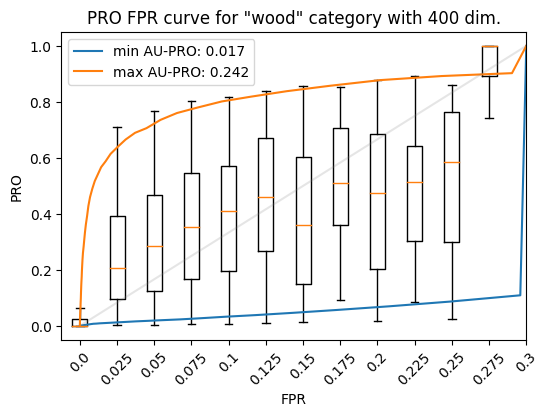

100%|██████████| 148/148 [00:01<00:00, 74.37it/s] 


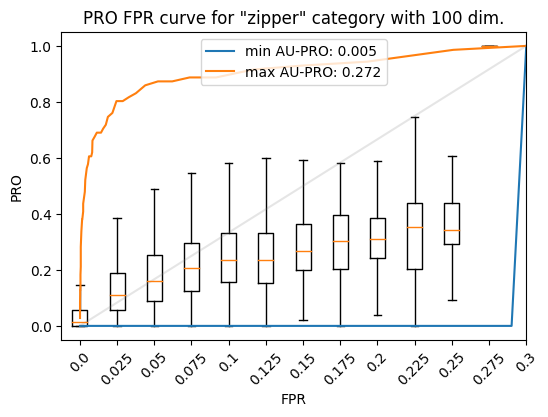

100%|██████████| 148/148 [00:06<00:00, 22.48it/s]


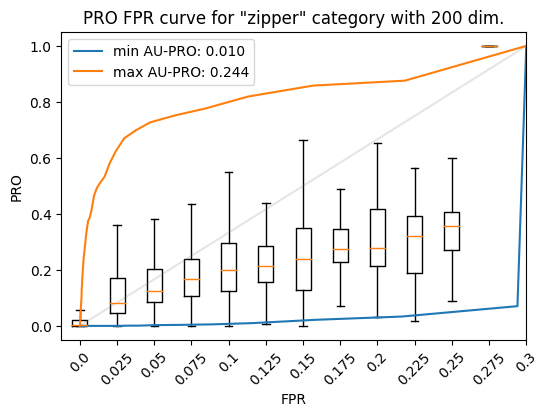

100%|██████████| 148/148 [00:30<00:00,  4.77it/s]


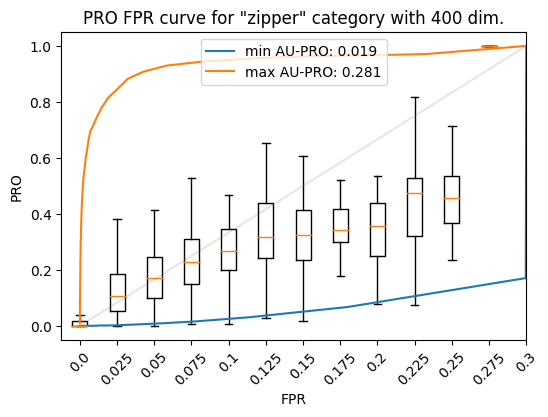

100%|██████████| 148/148 [00:01<00:00, 96.17it/s]


In [13]:
all_cats, all_dims, all_aurocs, all_thr, all_ths_reults = [], [], [], [], []

for category in all_categories:
    for resize_dim in all_resize_dim:
        all_results = run_all(category, resize_dim)
        all_cats.append(category)
        all_dims.append(resize_dim)
        all_aurocs.append(all_results['auroc'])
        all_thr.append(all_results['optimal_threshold'])
        all_ths_reults.append(all_results['threshold_based_metrics'])
        

In [14]:
df_autoencoder_results = pd.DataFrame()
df_autoencoder_results['category'] = all_cats
df_autoencoder_results['resize_dim'] = all_dims
df_autoencoder_results['AUROC'] = all_aurocs
df_autoencoder_results['optimal_threshold'] = all_thr
df_autoencoder_results['threshold_results'] = all_ths_reults

In [15]:
filename = '../results/autoencoder_pro_fpr/values_all'
df_autoencoder_results.to_pickle(f"{filename}.pkl")  

In [25]:
def get_mean_auroc_results(dim):
    for idx, row in df_autoencoder_results.iterrows():
        if row.resize_dim == dim:
            mean_auroc = row.AUROC['mean'][0]
            print(f'{row.category} | dim: {row.resize_dim} | meanAUROC: {mean_auroc:.4f}')
    return mean_auroc


In [26]:
mean_auroc = get_mean_auroc_results(100)

bottle | dim: 100 | meanAUROC: 0.6457
cable | dim: 100 | meanAUROC: 0.6138
capsule | dim: 100 | meanAUROC: 0.3305
carpet | dim: 100 | meanAUROC: 0.6834
grid | dim: 100 | meanAUROC: 0.6061
hazelnut | dim: 100 | meanAUROC: 0.9462
leather | dim: 100 | meanAUROC: 0.9092
metal_nut | dim: 100 | meanAUROC: 0.7780
pill | dim: 100 | meanAUROC: 0.8586
screw | dim: 100 | meanAUROC: 0.5319
tile | dim: 100 | meanAUROC: 0.5415
toothbrush | dim: 100 | meanAUROC: 0.8489
transistor | dim: 100 | meanAUROC: 0.6498
wood | dim: 100 | meanAUROC: 0.6772
zipper | dim: 100 | meanAUROC: 0.5819


In [17]:
np.mean(mean_auroc), np.std(mean_auroc)

(0.581881976691736, 0.0)

In [27]:
mean_auroc = get_mean_auroc_results(200)

bottle | dim: 200 | meanAUROC: 0.6577
cable | dim: 200 | meanAUROC: 0.5990
capsule | dim: 200 | meanAUROC: 0.6324
carpet | dim: 200 | meanAUROC: 0.6872
grid | dim: 200 | meanAUROC: 0.6561
hazelnut | dim: 200 | meanAUROC: 0.9534
leather | dim: 200 | meanAUROC: 0.8454
metal_nut | dim: 200 | meanAUROC: 0.7705
pill | dim: 200 | meanAUROC: 0.8304
screw | dim: 200 | meanAUROC: 0.6764
tile | dim: 200 | meanAUROC: 0.6499
toothbrush | dim: 200 | meanAUROC: 0.8687
transistor | dim: 200 | meanAUROC: 0.6692
wood | dim: 200 | meanAUROC: 0.5870
zipper | dim: 200 | meanAUROC: 0.5247


In [28]:
np.mean(mean_auroc), np.std(mean_auroc)

(0.5247371415894924, 0.0)

In [29]:
mean_auroc = get_mean_auroc_results(400)

bottle | dim: 400 | meanAUROC: 0.4938
cable | dim: 400 | meanAUROC: 0.5482
capsule | dim: 400 | meanAUROC: 0.6237
carpet | dim: 400 | meanAUROC: 0.6090
grid | dim: 400 | meanAUROC: 0.6626
hazelnut | dim: 400 | meanAUROC: 0.9416
leather | dim: 400 | meanAUROC: 0.7956
metal_nut | dim: 400 | meanAUROC: 0.7519
pill | dim: 400 | meanAUROC: 0.7783
screw | dim: 400 | meanAUROC: 0.6230
tile | dim: 400 | meanAUROC: 0.7003
toothbrush | dim: 400 | meanAUROC: 0.8599
transistor | dim: 400 | meanAUROC: 0.6162
wood | dim: 400 | meanAUROC: 0.6624
zipper | dim: 400 | meanAUROC: 0.5707


In [30]:
np.mean(mean_auroc), np.std(mean_auroc)

(0.5706853022519962, 0.0)

In [32]:
def get_all_boxplots_per_cat(dim):
    plt.rcParams['font.size'] = 10
    
    total_box_plots = len(df_autoencoder_results[df_autoencoder_results.resize_dim == dim])
    print(f"total box plots: {total_box_plots}")
    
    fig, ax = plt.subplots()
    for idx, row in df_autoencoder_results.iterrows():
        if row.resize_dim == dim:
            df_auroc = row['AUROC']
            boxes = [
                {
                    'label' : f"{row.category}",
                    'whislo': df_auroc['min'],    # Bottom whisker position
                    'q1'    : df_auroc['25%'],    # First quartile (25th percentile)
                    'med'   : df_auroc['50%'],    # Median         (50th percentile)
                    'q3'    : df_auroc['75%'],    # Third quartile (75th percentile)
                    'whishi': df_auroc['max'],    # Top whisker position
                    'fliers': []        # Outliers
                }
                ]
            ax.bxp(boxes, showfliers=False, positions=[idx], widths=([1]))
    plt.xticks(rotation=90)
    plt.ylabel('AUROC')
    plt.title(f'AUROC statistics per category for U-net with {dim} resizing')
    plt.show()
    

total box plots: 15


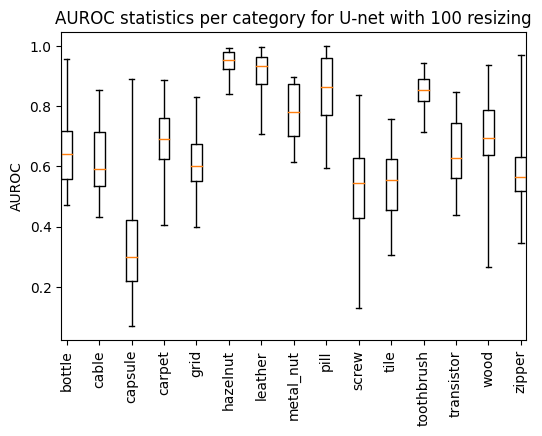

In [33]:
get_all_boxplots_per_cat(100)

total box plots: 15


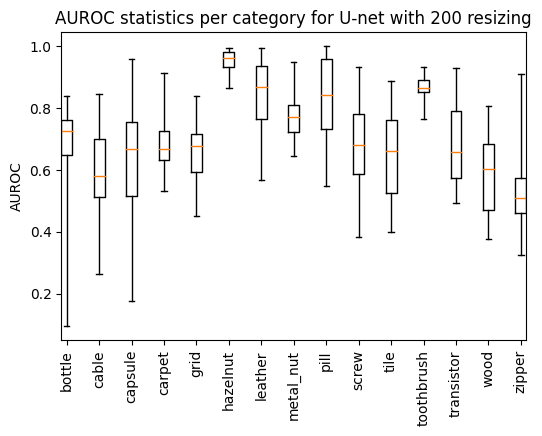

In [34]:
get_all_boxplots_per_cat(200)

total box plots: 15


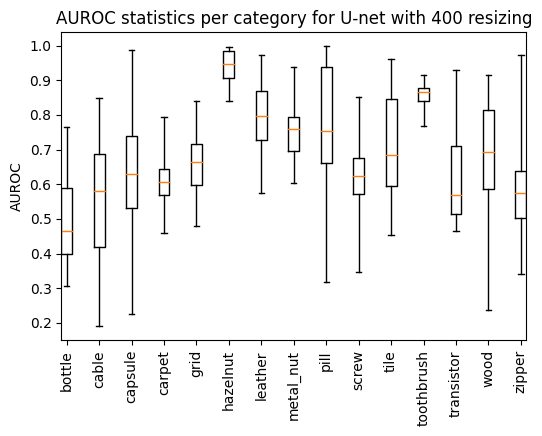

In [35]:
get_all_boxplots_per_cat(400)